In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_regression
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import os
from scipy import stats
from scipy.stats import jarque_bera, shapiro, kstest, normaltest
from scipy.stats import pearsonr, spearmanr
import optuna

# Handle different package versions gracefully
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.tsa.stattools import adfuller
    STATSMODELS_AVAILABLE = True
except ImportError:
    print("⚠️ Warning: statsmodels not available. Some statistical tests will be skipped.")
    STATSMODELS_AVAILABLE = False

try:
    from arch.unitroot import PhillipsPerron
    ARCH_AVAILABLE = True
except ImportError:
    print("⚠️ Warning: arch package not available. Phillips-Perron test will be skipped.")
    ARCH_AVAILABLE = False

try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except ImportError:
    print("⚠️ Warning: plotly not available. Interactive plots will be skipped.")
    PLOTLY_AVAILABLE = False

🧠 Standalone Bitcoin LSTM Prediction Model
🚀 Running Complete Bitcoin LSTM Analysis
✅ Successfully loaded: Bitcoin_12.2013_05.2025.csv
   Shape: (4190, 12)
   Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
✅ Data preprocessed: 4190 rows
   Date range: 2013-12-09 00:00:00+00:00 to 2025-05-29 00:00:00+00:00
   Price range: $178.10 - $111,673.28
🔧 Creating technical features...
✅ Technical features created
📊 Preparing LSTM data with sequence length: 30
   Using features: ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'macd', 'bb_position']
✅ Data prepared: 4160 sequences
   Input shape: (4160, 30, 8)
   Output shape: (4160,)
🚀 Training LSTM model...
   Using device: cpu
🧠 LSTM model created:
   Input size: 8
   Hidden size: 64
   Layers: 2
   Dropout: 0.3


/tmp/ipykernel_4222/635852056.py:130: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)


   Epochs: 100
   Batch size: 64
   Learning rate: 0.001

🔄 Training progress:
   Epoch   0: Train Loss: 0.039990, Val Loss: 0.377089
   Epoch  20: Train Loss: 0.005019, Val Loss: 0.020712
   Epoch  40: Train Loss: 0.003781, Val Loss: 0.145479
✋ Early stopping at epoch 41

📊 Evaluating model...

✅ Model Performance:
   MAE:  $9,911.26
   RMSE: $11,128.93
   R²:   0.7368
   MAPE: 22.68%


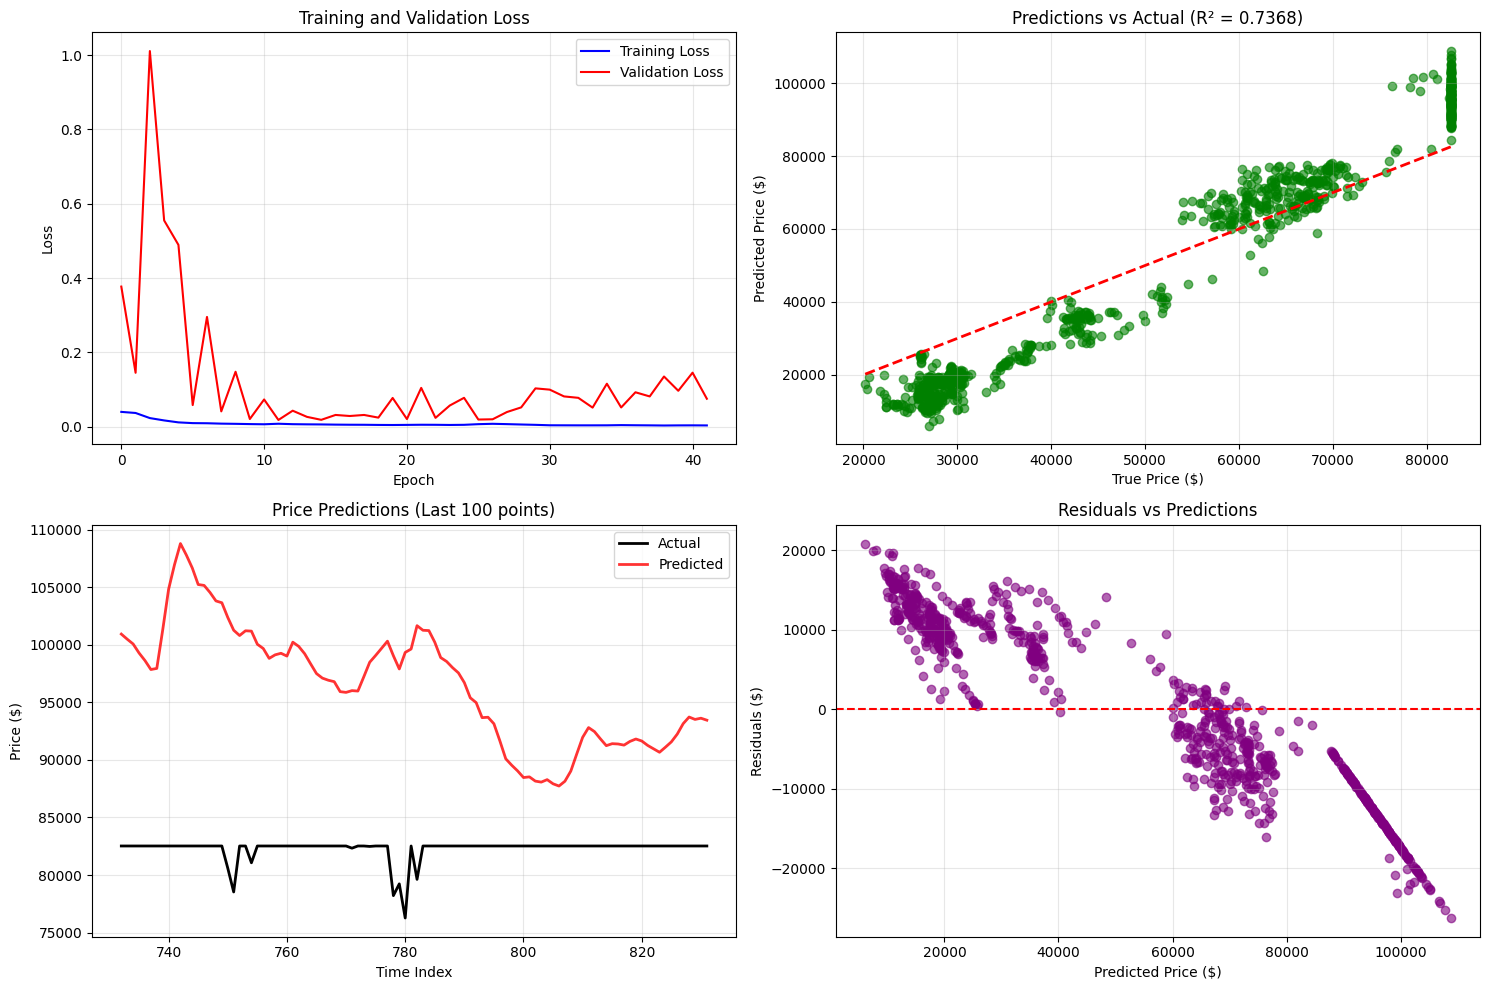

🔮 Predicting next 30 prices...
✅ Future predictions:
   Day 1: $5,083.66
   Day 2: $5,036.40
   Day 3: $5,014.15
   Day 4: $4,999.67
   Day 5: $4,988.00
   Day 6: $4,981.14
   Day 7: $4,976.67
   Day 8: $4,973.78
   Day 9: $4,971.91
   Day 10: $4,970.69

🎉 Analysis completed successfully!

📊 Final Results Summary:
R² Score: 0.7368
MAPE: 22.68%
Next prediction: $5,083.66


In [3]:
class StandaloneBitcoinLSTM:
    """
    Standalone Bitcoin LSTM prediction model
    """
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.sequence_scaler = MinMaxScaler()
        self.model = None
        
    def load_and_preprocess_data(self):
        """Load and preprocess Bitcoin data"""
        
        try:
            # Try different separators
            try:
                self.df = pd.read_csv(self.data_path, sep=';')
            except:
                self.df = pd.read_csv(self.data_path, sep=',')
            
            print(f"✅ Successfully loaded: {self.data_path}")
            print(f"   Shape: {self.df.shape}")
            print(f"   Columns: {list(self.df.columns)}")
            
        except FileNotFoundError:
            print(f"❌ File not found: {self.data_path}")
            return None
        
        # Clean column names
        self.df.columns = self.df.columns.str.strip().str.replace('"', '')
        
        # Handle different column name variations
        column_mapping = {
            'timeOpen': ['timeOpen', 'timestamp', 'date', 'time'],
            'open': ['open', 'Open'],
            'high': ['high', 'High'],
            'low': ['low', 'Low'], 
            'close': ['close', 'Close'],
            'volume': ['volume', 'Volume']
        }
        
        # Map columns to standard names
        for standard_name, possible_names in column_mapping.items():
            for possible_name in possible_names:
                if possible_name in self.df.columns:
                    if standard_name != possible_name:
                        self.df = self.df.rename(columns={possible_name: standard_name})
                    break
        
        # Ensure we have required columns
        required_cols = ['open', 'high', 'low', 'close']
        missing_cols = [col for col in required_cols if col not in self.df.columns]
        if missing_cols:
            print(f"❌ Missing required columns: {missing_cols}")
            return None
        
        # Parse datetime if exists
        if 'timeOpen' in self.df.columns:
            self.df['timeOpen'] = pd.to_datetime(self.df['timeOpen'].astype(str).str.replace('"', ''), errors='coerce')
            self.df = self.df.sort_values('timeOpen').reset_index(drop=True)
        
        # Convert numeric columns
        numeric_cols = ['open', 'high', 'low', 'close']
        if 'volume' in self.df.columns:
            numeric_cols.append('volume')
            
        for col in numeric_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        # Handle missing values
        self.df = self.df.dropna(subset=['open', 'high', 'low', 'close'])
        
        # Add volume if missing
        if 'volume' not in self.df.columns:
            self.df['volume'] = 1.0  # Default volume
        else:
            self.df['volume'] = self.df['volume'].fillna(1.0)
        
        print(f"✅ Data preprocessed: {len(self.df)} rows")
        print(f"   Date range: {self.df['timeOpen'].min() if 'timeOpen' in self.df.columns else 'No timestamp'} to {self.df['timeOpen'].max() if 'timeOpen' in self.df.columns else 'No timestamp'}")
        print(f"   Price range: ${self.df['close'].min():,.2f} - ${self.df['close'].max():,.2f}")
        
        return self.df
    
    def create_technical_features(self):
        """Create basic technical indicators for LSTM"""
        
        print("🔧 Creating technical features...")
        
        df = self.df.copy()
        
        # Simple moving averages
        df['sma_10'] = df['close'].rolling(window=10).mean()
        df['sma_20'] = df['close'].rolling(window=20).mean()
        
        # RSI
        def calculate_rsi(prices, window=14):
            delta = prices.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            return rsi
        
        df['rsi_14'] = calculate_rsi(df['close'], 14)
        
        # MACD
        ema_12 = df['close'].ewm(span=12).mean()
        ema_26 = df['close'].ewm(span=26).mean()
        df['macd'] = ema_12 - ema_26
        df['macd_signal'] = df['macd'].ewm(span=9).mean()
        
        # Bollinger Bands position
        bb_middle = df['close'].rolling(window=20).mean()
        bb_std = df['close'].rolling(window=20).std()
        bb_upper = bb_middle + (bb_std * 2)
        bb_lower = bb_middle - (bb_std * 2)
        df['bb_position'] = (df['close'] - bb_lower) / (bb_upper - bb_lower)
        
        # Price ratios
        df['high_low_ratio'] = df['high'] / df['low']
        df['close_open_ratio'] = df['close'] / df['open']
        
        # Returns and volatility
        df['returns'] = df['close'].pct_change()
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        # Fill missing values
        df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
        df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        self.df_enhanced = df
        print(f"✅ Technical features created")
        
        return df
    
    def prepare_lstm_data(self, sequence_length=30):
        """Prepare data for LSTM training"""
        
        print(f"📊 Preparing LSTM data with sequence length: {sequence_length}")
        
        # Select features for LSTM
        feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'macd', 'bb_position']
        available_features = [f for f in feature_cols if f in self.df_enhanced.columns]
        
        print(f"   Using features: {available_features}")
        
        # Extract data
        data = self.df_enhanced[available_features].values.astype('float32')
        
        # Remove outliers using IQR method
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data = np.clip(data, lower_bound, upper_bound)
        
        # Scale the data
        data_scaled = self.sequence_scaler.fit_transform(data)
        
        # Create sequences
        X_seq, y_seq = [], []
        
        for i in range(sequence_length, len(data_scaled)):
            X_seq.append(data_scaled[i-sequence_length:i])
            y_seq.append(data_scaled[i, 3])  # close price is at index 3
        
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)
        
        print(f"✅ Data prepared: {len(X_seq)} sequences")
        print(f"   Input shape: {X_seq.shape}")
        print(f"   Output shape: {y_seq.shape}")
        
        return X_seq, y_seq, available_features
    
    def create_lstm_model(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        """Create LSTM model"""
        
        class SimplifiedLSTM(nn.Module):
            def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
                super(SimplifiedLSTM, self).__init__()
                
                self.lstm = nn.LSTM(
                    input_size, hidden_size, num_layers,
                    batch_first=True, dropout=dropout if num_layers > 1 else 0
                )
                
                self.batch_norm = nn.BatchNorm1d(hidden_size)
                self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
                self.fc2 = nn.Linear(hidden_size // 2, 1)
                self.dropout = nn.Dropout(dropout)
                self.activation = nn.ReLU()
                
                self._init_weights()
                
            def _init_weights(self):
                for name, param in self.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        
            def forward(self, x):
                lstm_out, (h_n, c_n) = self.lstm(x)
                last_output = lstm_out[:, -1, :]
                
                if last_output.size(0) > 1:
                    last_output = self.batch_norm(last_output)
                
                x = self.dropout(self.activation(self.fc1(last_output)))
                output = self.fc2(x)
                
                return output
        
        model = SimplifiedLSTM(input_size, hidden_size, num_layers, dropout)
        print(f"🧠 LSTM model created:")
        print(f"   Input size: {input_size}")
        print(f"   Hidden size: {hidden_size}")
        print(f"   Layers: {num_layers}")
        print(f"   Dropout: {dropout}")
        
        return model
    
    def train_model(self, X_seq, y_seq, test_size=0.2, batch_size=64, epochs=200, learning_rate=0.001):
        """Train the LSTM model"""
        
        print("🚀 Training LSTM model...")
        
        # Split data
        split_idx = int(len(X_seq) * (1 - test_size))
        X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
        y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
        
        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        
        # Create model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"   Using device: {device}")
        
        input_size = X_seq.shape[2]
        self.model = self.create_lstm_model(input_size)
        self.model = self.model.to(device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=learning_rate, 
            weight_decay=0.01,
            betas=(0.9, 0.999)
        )
        
        # Learning rate scheduler (removed verbose parameter)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=15, factor=0.5
        )
        
        # Data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Training loop
        best_loss = float('inf')
        patience = 30
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        print(f"   Epochs: {epochs}")
        print(f"   Batch size: {batch_size}")
        print(f"   Learning rate: {learning_rate}")
        print("\n🔄 Training progress:")
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                output = self.model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                
                optimizer.step()
                train_loss += loss.item()
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in test_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    output = self.model(batch_x)
                    val_loss += criterion(output, batch_y).item()
            
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(test_loader)
            
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            
            scheduler.step(avg_val_loss)
            
            # Early stopping
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_lstm_model.pth')
            else:
                patience_counter += 1
                
            # Print progress
            if epoch % 20 == 0 or epoch == epochs - 1:
                print(f"   Epoch {epoch:3d}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
                
            # Early stopping check
            if patience_counter >= patience:
                print(f"✋ Early stopping at epoch {epoch}")
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_lstm_model.pth'))
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'X_test': X_test,
            'y_test': y_test,
            'X_test_tensor': X_test_tensor,
            'y_test_tensor': y_test_tensor,
            'device': device
        }
    
    def evaluate_model(self, training_results, available_features):
        """Evaluate the trained model"""
        
        print("\n📊 Evaluating model...")
        
        device = training_results['device']
        X_test_tensor = training_results['X_test_tensor']
        y_test = training_results['y_test']
        
        # Make predictions
        self.model.eval()
        with torch.no_grad():
            X_test_device = X_test_tensor.to(device)
            y_pred_scaled = self.model(X_test_device).cpu().numpy()
        
        # Inverse transform predictions
        dummy_data = np.zeros((len(y_pred_scaled), len(available_features)))
        dummy_data[:, 3] = y_pred_scaled.flatten()  # close price at index 3
        y_pred_original = self.sequence_scaler.inverse_transform(dummy_data)[:, 3]
        
        dummy_data[:, 3] = y_test
        y_test_original = self.sequence_scaler.inverse_transform(dummy_data)[:, 3]
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_original, y_pred_original)
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        r2 = r2_score(y_test_original, y_pred_original)
        mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
        
        print(f"\n✅ Model Performance:")
        print(f"   MAE:  ${mae:,.2f}")
        print(f"   RMSE: ${rmse:,.2f}")
        print(f"   R²:   {r2:.4f}")
        print(f"   MAPE: {mape:.2f}%")
        
        # Plot results
        self.plot_results(y_test_original, y_pred_original, training_results['train_losses'], training_results['val_losses'])
        
        return {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'y_true': y_test_original,
            'y_pred': y_pred_original
        }
    
    def plot_results(self, y_true, y_pred, train_losses, val_losses):
        """Plot training results and predictions"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Training losses
        axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
        axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Predictions vs actual (scatter)
        axes[0, 1].scatter(y_true, y_pred, alpha=0.6, color='green')
        axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        axes[0, 1].set_title(f'Predictions vs Actual (R² = {r2_score(y_true, y_pred):.4f})')
        axes[0, 1].set_xlabel('True Price ($)')
        axes[0, 1].set_ylabel('Predicted Price ($)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Time series plot (last 100 points)
        plot_len = min(100, len(y_true))
        indices = range(len(y_true) - plot_len, len(y_true))
        
        axes[1, 0].plot(indices, y_true[-plot_len:], label='Actual', color='black', linewidth=2)
        axes[1, 0].plot(indices, y_pred[-plot_len:], label='Predicted', color='red', linewidth=2, alpha=0.8)
        axes[1, 0].set_title(f'Price Predictions (Last {plot_len} points)')
        axes[1, 0].set_xlabel('Time Index')
        axes[1, 0].set_ylabel('Price ($)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Residuals
        residuals = y_true - y_pred
        axes[1, 1].scatter(y_pred, residuals, alpha=0.6, color='purple')
        axes[1, 1].axhline(y=0, color='red', linestyle='--')
        axes[1, 1].set_title('Residuals vs Predictions')
        axes[1, 1].set_xlabel('Predicted Price ($)')
        axes[1, 1].set_ylabel('Residuals ($)')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def predict_future(self, n_steps=30):
        """Predict future prices"""
        
        if self.model is None:
            print("❌ Model not trained yet!")
            return None
        
        print(f"🔮 Predicting next {n_steps} prices...")
        
        # Get last sequence from training data
        feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'macd', 'bb_position']
        available_features = [f for f in feature_cols if f in self.df_enhanced.columns]
        
        data = self.df_enhanced[available_features].values.astype('float32')
        data_scaled = self.sequence_scaler.transform(data)
        
        # Start with last 30 points
        sequence_length = 30
        last_sequence = data_scaled[-sequence_length:].reshape(1, sequence_length, -1)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.eval()
        
        predictions = []
        current_sequence = torch.tensor(last_sequence, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            for _ in range(n_steps):
                # Predict next value
                pred = self.model(current_sequence)
                predictions.append(pred.cpu().item())
                
                # Update sequence (simplified - just using close price prediction)
                # In practice, you'd need to predict all features or use a different approach
                new_point = current_sequence[0, -1, :].clone()
                new_point[3] = pred.item()  # Update close price
                
                # Roll the sequence
                current_sequence = torch.cat([
                    current_sequence[:, 1:, :],
                    new_point.unsqueeze(0).unsqueeze(0)
                ], dim=1)
        
        # Inverse transform predictions
        dummy_data = np.zeros((len(predictions), len(available_features)))
        dummy_data[:, 3] = predictions
        future_prices = self.sequence_scaler.inverse_transform(dummy_data)[:, 3]
        
        print(f"✅ Future predictions:")
        for i, price in enumerate(future_prices[:10], 1):  # Show first 10
            print(f"   Day {i}: ${price:,.2f}")
        
        return future_prices
    
    def run_complete_analysis(self, sequence_length=30, epochs=200):
        """Run complete LSTM analysis pipeline"""
        
        print("🚀 Running Complete Bitcoin LSTM Analysis")
        print("=" * 50)
        
        try:
            # 1. Load data
            if self.load_and_preprocess_data() is None:
                return None
            
            # 2. Create features
            self.create_technical_features()
            
            # 3. Prepare LSTM data
            X_seq, y_seq, available_features = self.prepare_lstm_data(sequence_length)
            
            # 4. Train model
            training_results = self.train_model(X_seq, y_seq, epochs=epochs)
            
            # 5. Evaluate model
            evaluation_results = self.evaluate_model(training_results, available_features)
            
            # 6. Predict future
            future_predictions = self.predict_future(30)
            
            print("\n🎉 Analysis completed successfully!")
            
            return {
                'evaluation': evaluation_results,
                'training': training_results,
                'future_predictions': future_predictions,
                'model': self.model
            }
            
        except Exception as e:
            print(f"\n❌ Error in analysis: {str(e)}")
            import traceback
            print(f"Full traceback:\n{traceback.format_exc()}")
            return None

# Usage example
if __name__ == "__main__":
    print("🧠 Standalone Bitcoin LSTM Prediction Model")
    print("=" * 50)
    
    # Initialize and run
    lstm_model = StandaloneBitcoinLSTM("Bitcoin_12.2013_05.2025.csv")
    results = lstm_model.run_complete_analysis(sequence_length=30, epochs=100)
    
    if results:
        print(f"\n📊 Final Results Summary:")
        print(f"R² Score: {results['evaluation']['r2']:.4f}")
        print(f"MAPE: {results['evaluation']['mape']:.2f}%")
        print(f"Next prediction: ${results['future_predictions'][0]:,.2f}")

🚀 Running Complete Bitcoin LSTM Analysis
✅ Successfully loaded: Bitcoin_12.2013_05.2025.csv
   Shape: (4190, 12)
   Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
✅ Data preprocessed: 4190 rows
   Date range: 2013-12-09 00:00:00+00:00 to 2025-05-29 00:00:00+00:00
   Price range: $178.10 - $111,673.28
🔧 Creating technical features...
✅ Technical features created
📊 Preparing LSTM data with sequence length: 30
   Using features: ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'macd', 'bb_position']
✅ Data prepared: 4160 sequences
   Input shape: (4160, 30, 8)
   Output shape: (4160,)
🚀 Training LSTM model...
   Using device: cpu
🧠 LSTM model created:
   Input size: 8
   Hidden size: 64
   Layers: 2
   Dropout: 0.3
   Epochs: 100
   Batch size: 64
   Learning rate: 0.001

🔄 Training progress:


/tmp/ipykernel_4222/635852056.py:130: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)


   Epoch   0: Train Loss: 0.039479, Val Loss: 0.295665
   Epoch  20: Train Loss: 0.006589, Val Loss: 0.069850
   Epoch  40: Train Loss: 0.003585, Val Loss: 0.027500
✋ Early stopping at epoch 52

📊 Evaluating model...

✅ Model Performance:
   MAE:  $8,092.66
   RMSE: $9,517.04
   R²:   0.8075
   MAPE: 20.52%


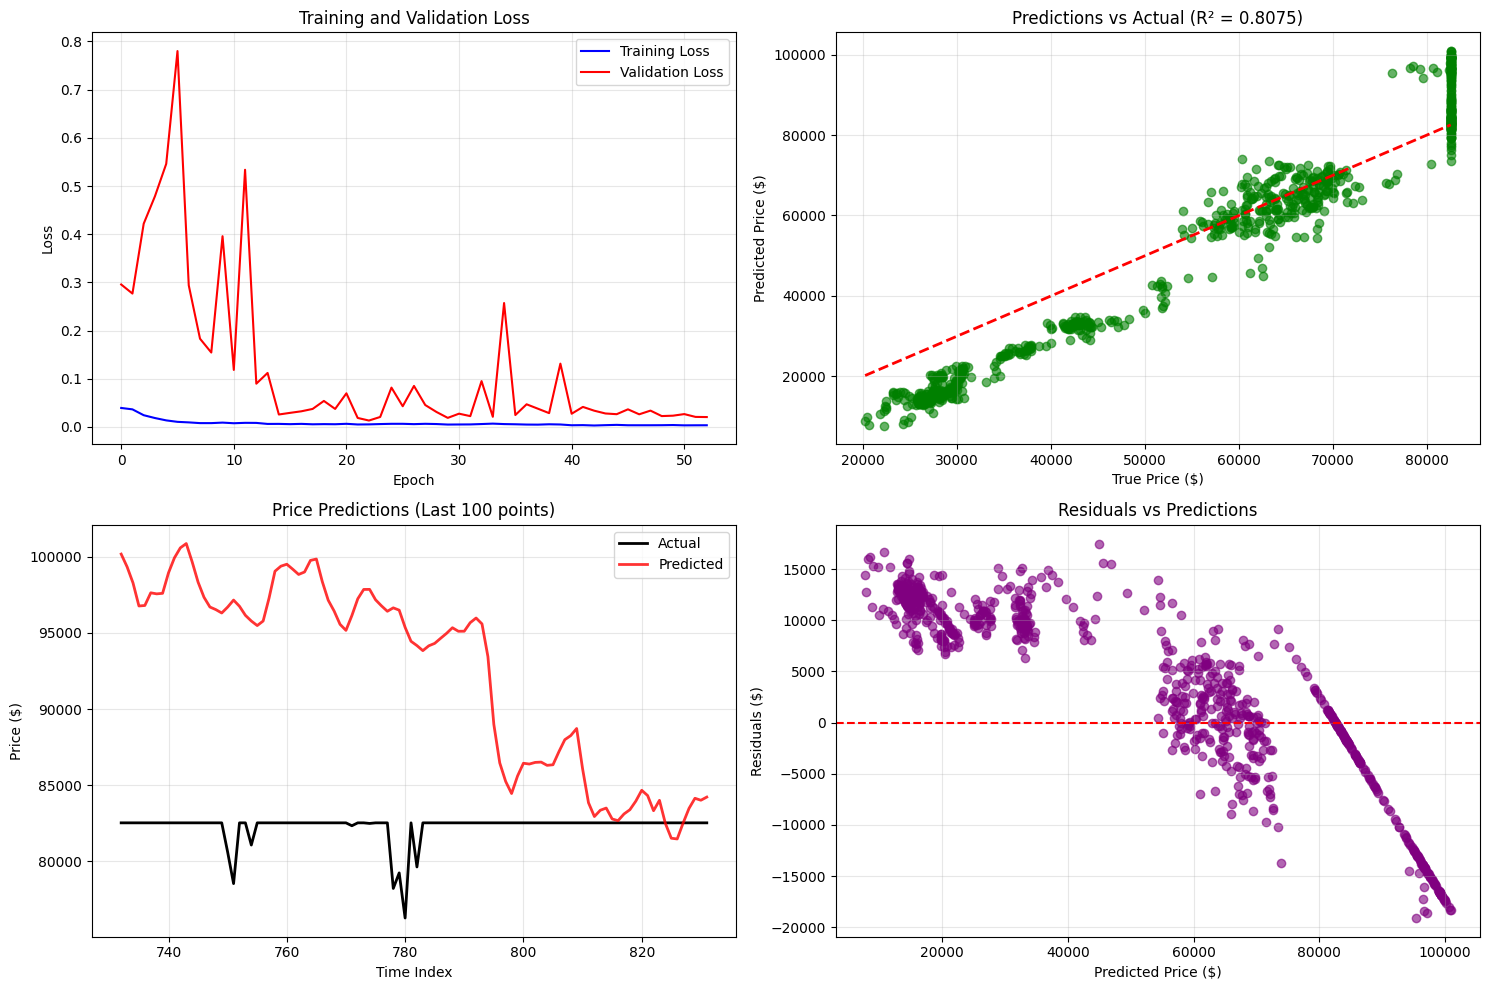

🔮 Predicting next 30 prices...
✅ Future predictions:
   Day 1: $5,265.63
   Day 2: $5,224.24
   Day 3: $5,206.59
   Day 4: $5,195.56
   Day 5: $5,188.47
   Day 6: $5,183.82
   Day 7: $5,180.77
   Day 8: $5,178.77
   Day 9: $5,177.45
   Day 10: $5,176.58

🎉 Analysis completed successfully!


In [5]:
import json

results = lstm_model.run_complete_analysis(sequence_length=30, epochs=100)
y_true = results['evaluation']['y_true']
y_pred = results['evaluation']['y_pred']

with open("standalone_lstm_output.json", "w") as f:
    json.dump({
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist()
    }, f)


In [6]:
with open("standalone_lstm_output.json", "w") as f:
    json.dump({
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist()
    }, f)


In [7]:
import json

# If you still have access to the results object
y_true = results['evaluation']['y_true']
y_pred = results['evaluation']['y_pred']

# Save the predictions
with open("standalone_lstm_output.json", "w") as f:
    json.dump({
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist()
    }, f)

print("✅ File saved as standalone_lstm_output.json")



✅ File saved as standalone_lstm_output.json
